<a href="https://colab.research.google.com/github/kashindra-mahato/Computer-Vision/blob/main/Image_Classification_from_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   109M      0  0:00:07  0:00:07 --:--:-- 90.4M


In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   kagglecatsanddogs_5340.zip   PetImages  'readme[1].txt'   sample_data


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os
import glob

num_skipped = 0
for folder_name in ('Cat', 'Dog'):
  folder_path = os.path.join("PetImages", folder_name)

  for fpath in glob.glob(os.path.join(folder_path, '*.jpg')):
    try:
      with open(fpath, "rb") as fobj:
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)

        if not is_jfif:
          num_skipped += 1
          # Delete corrupted image
          os.remove(fpath)

    except Exception as e:
      print(f"Error processing file {fpath}: {e}")

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


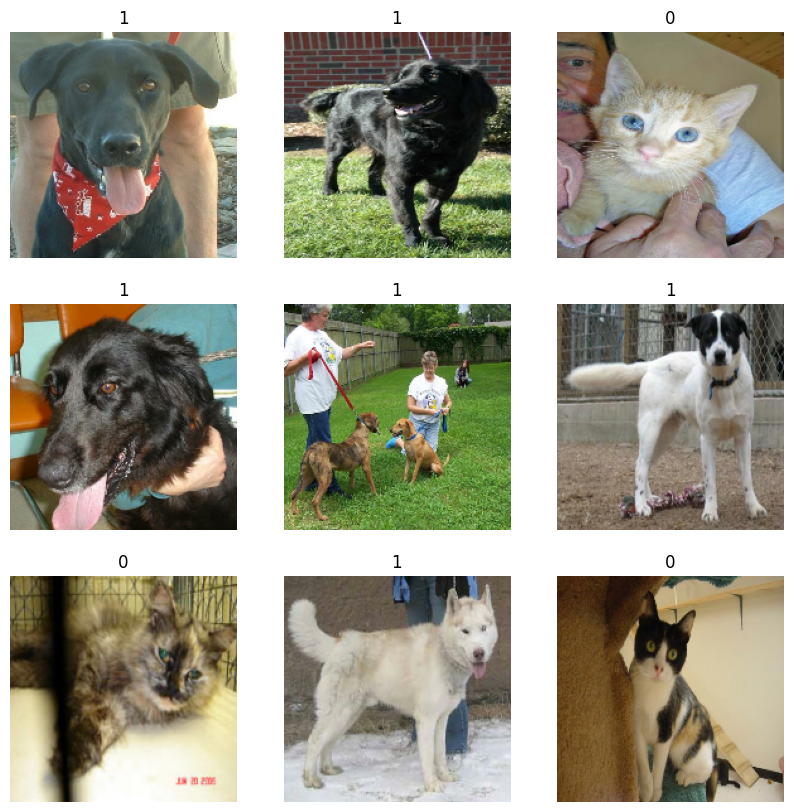

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1)
    ]
)

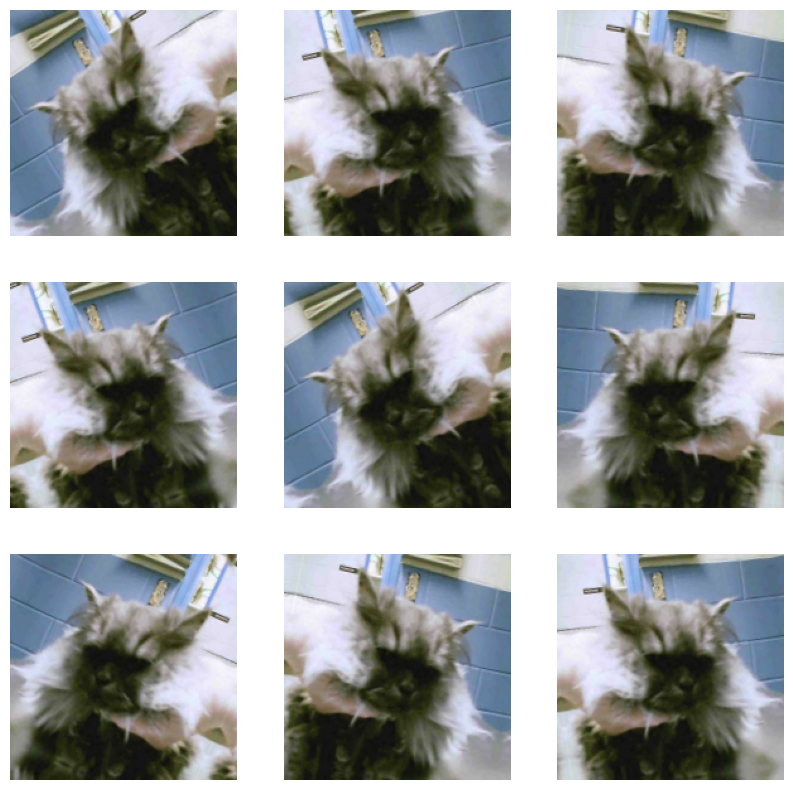

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# Apply 'data_augmentation' to the training images
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img),label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

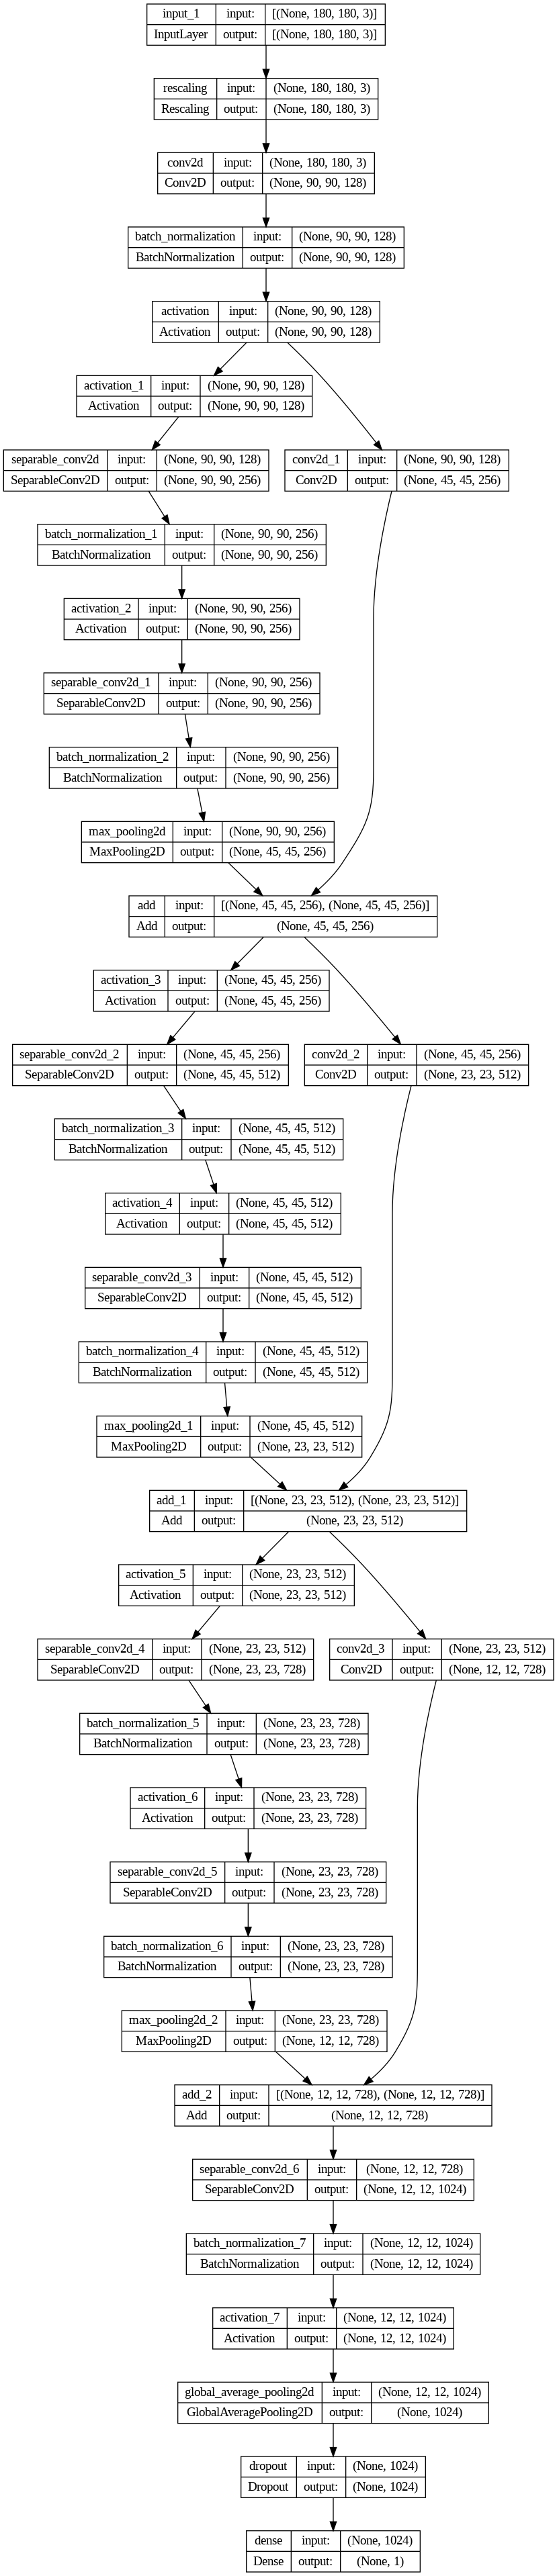

In [ ]:
def make_model(input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x # Set aside residual

  for size in [256, 512, 728]:
    x =  layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Project residual
    residual = layers.Conv2D(size, 1, strides=2, padding="same")(
        previous_block_activation
    )
    x = layers.add([x, residual]) # Add back residual
    previous_block_activation = x # Set aside next residual

  x = layers.SeparableConv2D(1024, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
    activation = "sigmoid"
    units = 1

  else:
    activation = "softmax"
    units = num_classes

  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(units, activation=activation)(x)
  return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
147/147 [==============================] - 270s 2s/step - loss: 0.6500 - accuracy: 0.6381 - val_loss: 0.8245 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 231s 2s/step - loss: 0.5144 - accuracy: 0.7472 - val_loss: 1.4613 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 232s 2s/step - loss: 0.3933 - accuracy: 0.8234 - val_loss: 1.5063 - val_accuracy: 0.4957
Epoch 4/25
147/147 [==============================] - 232s 2s/step - loss: 0.3379 - accuracy: 0.8533 - val_loss: 1.0785 - val_accuracy: 0.5758
Epoch 5/25
147/147 [==============================] - 237s 2s/step - loss: 0.2891 - accuracy: 0.8786 - val_loss: 0.4789 - val_accuracy: 0.7589
Epoch 6/25
147/147 [==============================] - 232s 2s/step - loss: 0.2467 - accuracy: 0.8971 - val_loss: 1.1623 - val_accuracy: 0.6435
Epoch 7/25
147/147 [==============================] - 232s 2s/step - loss: 0.2109 - accuracy: 0.9146 - val_loss: 0.2504 - val_accuracy: 0.8947

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks')

1/1 [==============================] - 2s 2s/step
This image is  54.51% can and  45.49% dog.


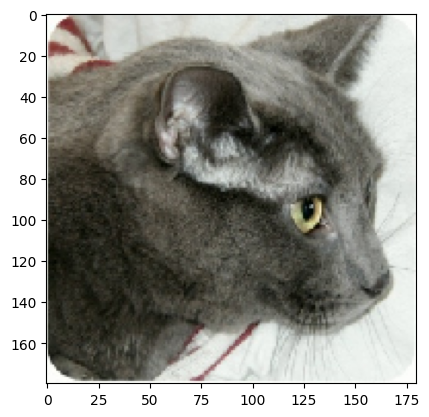

In [ ]:
img = keras.utils.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
plt.imshow(img)
img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score): .2f}% can and {100 * score: .2f}% dog.")